# Why we should use balances and machine learning for ionome diagnosis: the visual example

This is the first of the two companion notebooks for the paper [*Why we should use balances and machine learning for ionome diagnosis*](https://www.authorea.com/users/23640/articles/281937-why-we-should-use-balances-and-machine-learning-for-ionome-diagnosis). In the paper, I present how isometric log-ratios can help the diagnosis of nutrient contents in plant tissues (the ionome), and how machine learning can detect important patterns in health diagnosis.

The computations for the proof of concept are described in this first notebook 🥇, in the R statistical langage.

I need the tidyverse meta-package and the sf package.

In [1]:
library("tidyverse")
library("sf")
library("magick")
set.seed(7576273) # random.org

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Linking to GEOS 3.6.2, GDAL 2.2.3, PROJ 4.9.3

Linking to ImageMagick 6.9.7.4
Enabled features: fontconfig, freetype, fftw, lcms, pango, x11
Disabled features: cairo, ghostscript, rsvg, webp



The Îles-de-la-Madeleine map is loaded from a shapefile I created with QGIS from a Quebec coastline shapefile.

Reading layer `idm' from data source `/home/essi/Git/2020_ionome-ilr-ml/idm/idm.shp' using driver `ESRI Shapefile'
Simple feature collection with 33 features and 0 fields
geometry type:  LINESTRING
dimension:      XY
bbox:           xmin: -62.0212 ymin: 47.21173 xmax: -61.38654 ymax: 47.80287
epsg (SRID):    4326
proj4string:    +proj=longlat +datum=WGS84 +no_defs


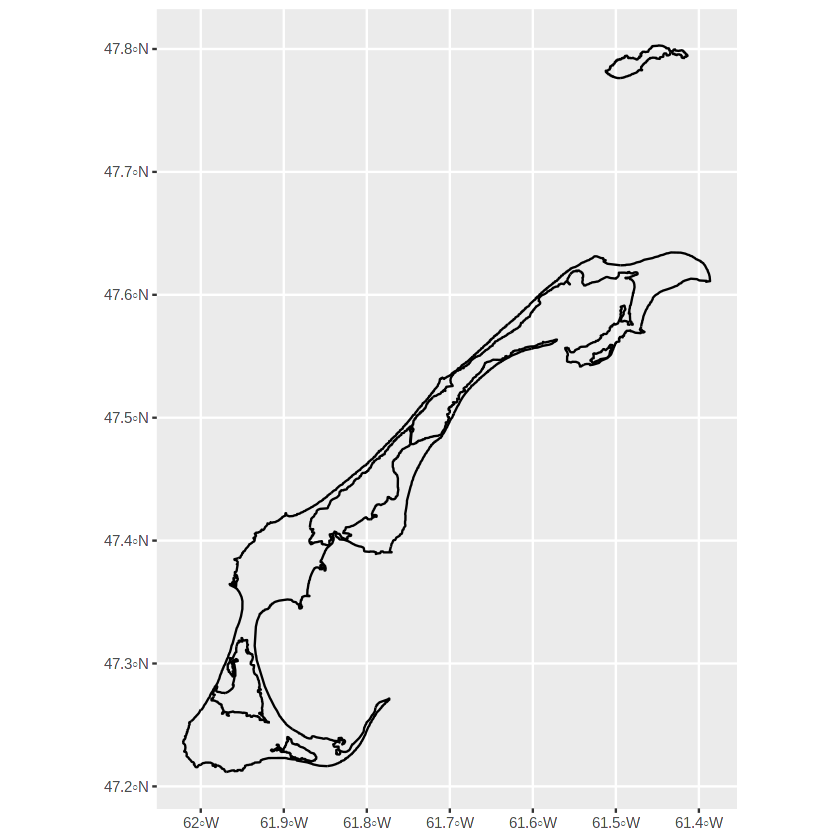

In [2]:
idm_map <- sf::st_read("idm/idm.shp")
ggplot(idm_map) + 
  geom_sf()

I created a grid where land and sea points will be identified.

In [3]:
xlims <- c(-62.5, -61)
ylims <- c(47, 48)

In [4]:
seq_x <- seq(from=xlims[1], to=xlims[2], by=0.01)
seq_y <- seq(from=ylims[1], to=ylims[2], by=0.01)
grid <- data.frame(expand.grid(long=seq_x, lat=seq_y))
grid$no <- 1:nrow(grid)
grid$area <- "sea"

I couldn't find a proper way to map the grid using he coastline so I manually changed the tag of earth points: half an hour of work, not that bad 😜.

In [5]:
is_in <- c(3372:3379, 3385:3390,
          3522:3532, 3534, 3537:3540, 3542,
          3673:3687, 3689, 3692, 3694,
          3825:3836, 3846,
          3977:3982, 3984:3986, 3998,
          4129, 4136, 4150,
          4281, 4282, 4286,
          4433, 4434, 4437,
          4584, 4585, 4587, 4588,
          4736, 4738,
          4887:4889,
          5039, 5040,
          5190:5192,
          5341:5345, 5347, 5348,
          5492:5500,
          5642:5651,
          5794:5804,
          5945:5955, 5962,
          6098:6104, 6107:6114,
          6250:6255, 6260:6266,
          6403:6406, 6414:6417,
          6558, 6559, 6566:6568,
          6711, 6712, 6719, 6720,
          6864, 6865, 6870, 6871,
          7017, 7020:7023,
          7170, 7172:7175,
          7322, 7324:7327,
          7474, 7475,
          7627, 7631,
          7779, 7783,
          7931, 7932, 7935,
          8083, 8084, 8087,
          8236, 8239, 8240, 8251,
          8389, 8393, 8400:8403, 8405,
          8542, 8548, 8549, 8554:8557,
          8694, 8695, 8707:8711,
          8847, 8848, 8861, 8862,
          9000, 9011:9014,
          9152, 9163:9166,
          9305, 9306, 9314:9320,
          9458:9474,
          9611, 9612, 9619:9623,
          11878:11881,
          12030:12033,
          12185:12187, 12189)
grid$area[is_in] <- "land"

If we want to **predict** something, we must evaluate the prediction with data that are not used to fit the model. I'm using 70% to train my models and the remaining 30% to test it.

In [6]:
train_id <- sample(1:nrow(grid), size = floor(0.7*nrow(grid)))
grid <- grid %>% mutate(is_train = 1:nrow(grid) %in% train_id)

Which gives the map.

Saving 6.67 x 6.67 in image



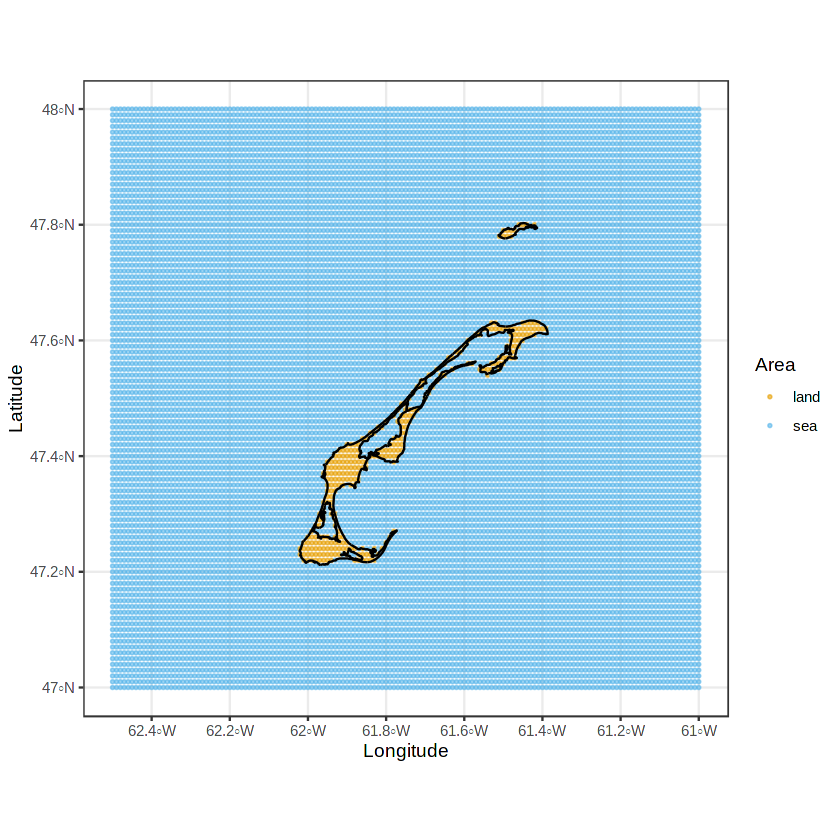

In [7]:
ggplot(idm_map) + 
  geom_point(data=grid, aes(x=long, y=lat, colour=area), size=0.5, alpha = 0.6) + # shape = ifelse(grid$is_train, "train", "test")
  geom_sf() + 
  scale_color_manual(values=c("#E69F00", "#56B4E9"), name = "Area") +
  #scale_shape_discrete(name = "Data set") +
  labs(x = "Longitude", y = "Latitude") +
  theme_bw()
ggsave("images/idm-grid.png", dpi = 300)

## Confidence range

As a parachitist, earth is the target state in the coodinates space. Would you use univariate confidence interval enclosing 95% of the deviation of the theoretical distribution?

In [8]:
land_tr <- grid %>% 
  dplyr::filter(area == "land", is_train) %>%
  dplyr::select(long, lat)

sea_tr <- grid %>% 
  dplyr::filter(area == "sea", is_train) %>%
  dplyr::select(long, lat)

In [9]:
long_dev <- qnorm(0.975)*sd(land_tr$long)
long_mean <- mean(land_tr$long)
lat_dev <- qnorm(0.975)*sd(land_tr$lat)
lat_mean <- mean(land_tr$lat)

long_ll <- long_mean - long_dev
long_ul <- long_mean + long_dev
lat_ll <- lat_mean - lat_dev
lat_ul <- lat_mean + lat_dev

confidence_box <- data.frame(long = c(long_ll, long_ul, long_ul, long_ll),
                             lat = c(lat_ll, lat_ll, lat_ul, lat_ul))

Saving 6.67 x 6.67 in image



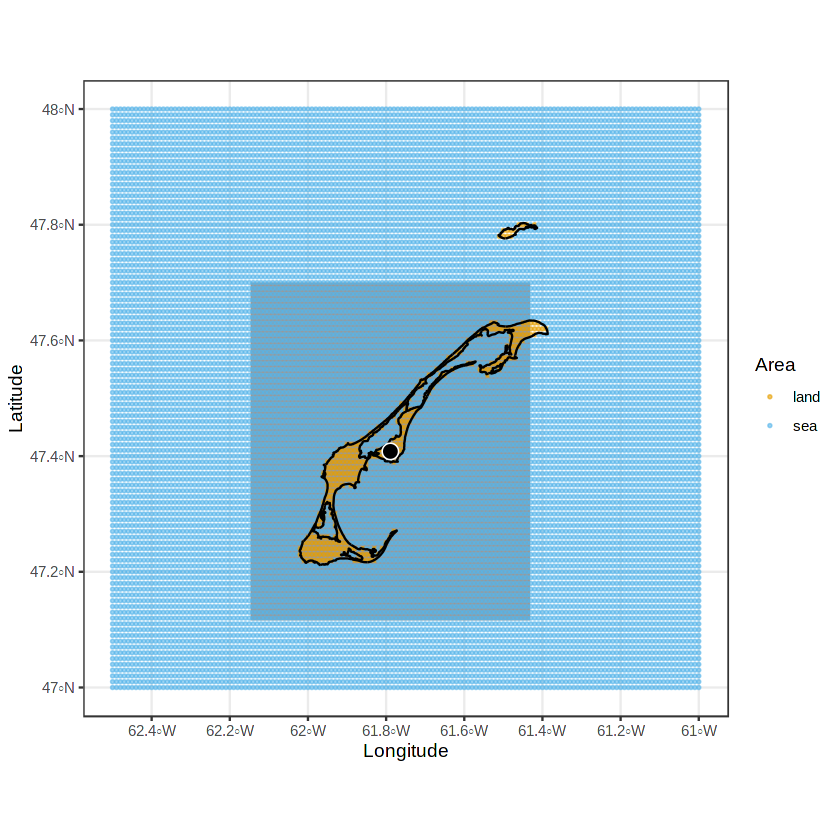

In [10]:
ggplot(idm_map) +
  geom_polygon(data = confidence_box, aes(x=long, y=lat), fill="gray60") +
  geom_point(data=grid, aes(x=long, y=lat, colour=area), size=0.5, alpha = 0.6) +
  geom_sf() + 
  geom_point(data = data.frame(long = long_mean, lat = lat_mean), 
             aes(x=long, y=lat), size=4, shape=21, colour = "white", fill = "black") +
  scale_color_manual(values=c("#E69F00", "#56B4E9"), name = "Area") +
  labs(x = "Longitude", y = "Latitude") +
  theme_bw()
ggsave("images/idm-confidence-box.png", dpi = 300)

Compute the negative predictive value.

In [11]:
grid %>%
  filter(long > long_ll, long < long_ul, lat > lat_ll, lat < lat_ul, !is_train) %>%
  count(area) %>%
  mutate(prop = prop.table(n))

area n    prop      
1 land   97 0.07879773
2 sea  1134 0.92120227

Fortunatly for our paracutist, the mean is on land... but only a proportion of 8% of the points enclosed in the confidence box are on land. Moreover we completely miss the northern island (Île Biron).

# Mahalanobis distance

In previous papers, we used the Mahalanobis multivariate distance to avoid using collection of univariate ranges. Let's see how it behaves on our archipellago with the mahalanobis distance to define the target.

In [12]:
grid$maha_dist <- sqrt(mahalanobis(x = grid[c('long', 'lat')], center = colMeans(land_tr), cov = cov(land_tr)))

To draw the ellipse, we can use this package:

In [13]:
library("ellipse")


Attaching package: ‘ellipse’


The following object is masked from ‘package:graphics’:

    pairs




In [14]:
deviation_ell <- data.frame(ellipse(x=cov(land_tr), centre = colMeans(land_tr), level=0.95))

Saving 6.67 x 6.67 in image



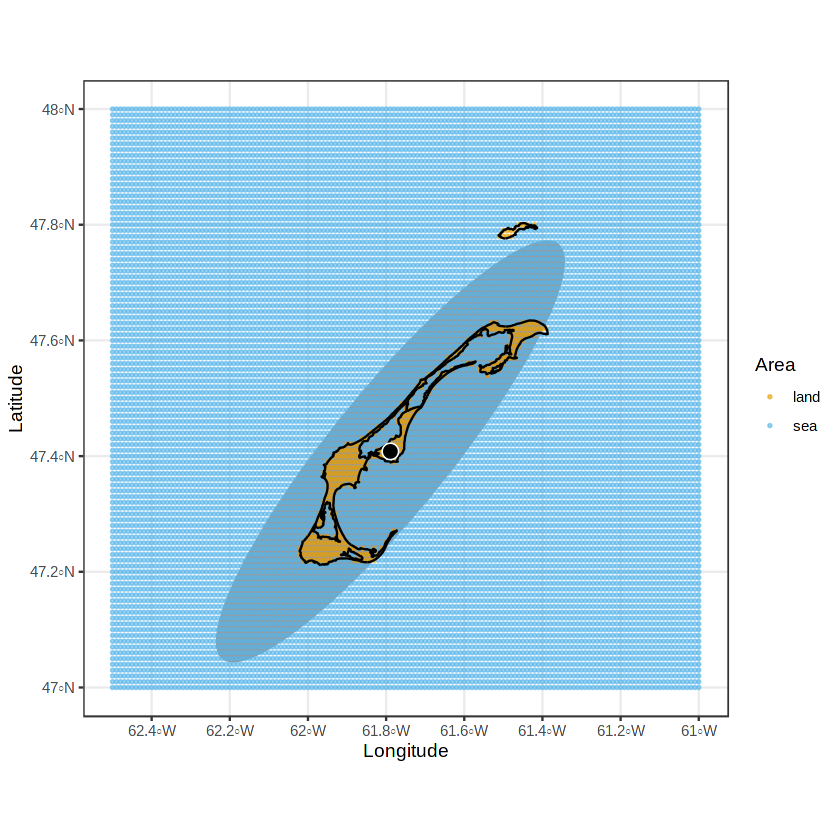

In [15]:
ggplot(idm_map) +
  geom_polygon(data = deviation_ell, aes(x=long, y=lat), fill="gray60") +
  geom_point(data=grid, aes(x=long, y=lat, colour=area), size=0.5, alpha=0.6) +
  geom_sf() + 
  geom_point(data = data.frame(long = long_mean, lat = lat_mean), 
             aes(x=long, y=lat), size=4, shape=21, colour = "white", fill = "black") +
  scale_color_manual(values=c("#E69F00", "#56B4E9"), name = "Area") +
  labs(x = "Longitude", y = "Latitude") +
  theme_bw()
ggsave("images/idm-ellipse.png")

In [16]:
grid %>%
  filter(maha_dist < sqrt(qchisq(0.95, df=2)), !is_train) %>%
  count(area) %>%
  mutate(prop = prop.table(n))

area n   prop     
1 land 100 0.1497006
2 sea  568 0.8502994

The parachutist has a 15% chance of falling on land given this model. The northern island is missed again.

# Machine learning

Last chance: machine learning. I'm going to use knns since we are in a eucledian space.

In [17]:
library("caret")

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




In [18]:
knn_model <- train(x = as.matrix(grid[grid$is_train, c("long", "lat")]),
                   y = as.factor(grid$area)[grid$is_train],
                   method = "knn",
                   tuneGrid = data.frame(k=c(3, 5, 10)))
knn_model

k-Nearest Neighbors 

10675 samples
    2 predictor
    2 classes: 'land', 'sea' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 10675, 10675, 10675, 10675, 10675, 10675, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   3  0.9873110  0.6372569
   5  0.9871466  0.6181353
  10  0.9870037  0.5808886

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 3.

In [19]:
grid$pred_knn <- predict(knn_model, newdata = as.matrix(grid[, c("long", "lat")]))
grid$`Probability of land` <- predict(knn_model, newdata = as.matrix(grid[, c("long", "lat")]), type = "prob")[, 1]

Saving 6.67 x 6.67 in image



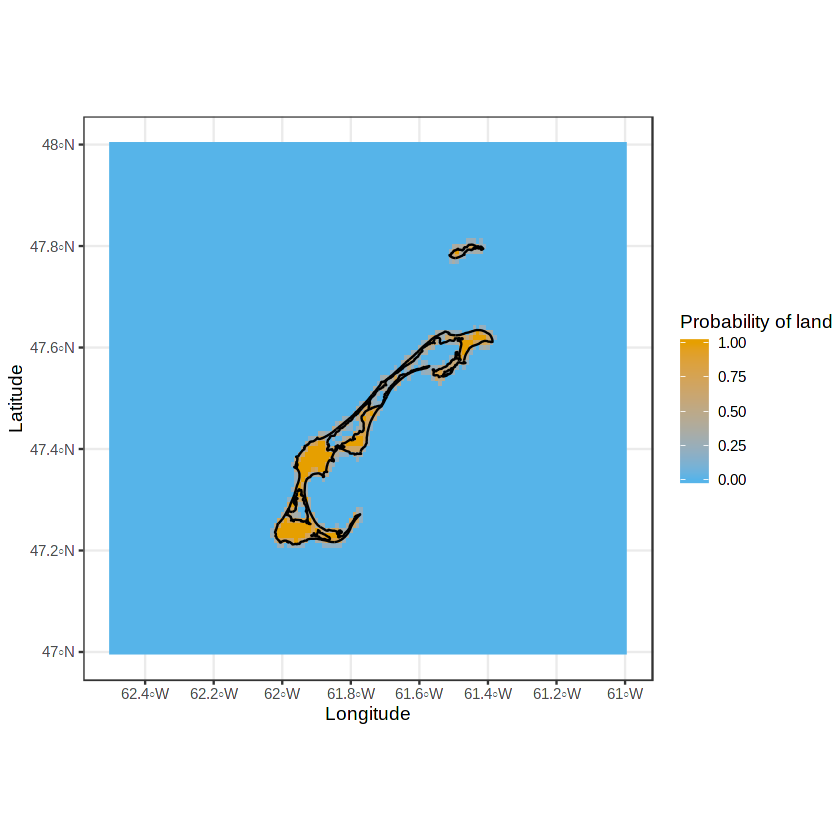

In [20]:
ggplot(idm_map) +
  geom_raster(data = grid, aes(x=long, y=lat, fill = `Probability of land`)) +
  geom_sf() + 
  scale_fill_continuous(high="#E69F00", low="#56B4E9") +
  labs(x = "Longitude", y = "Latitude") +
  theme_bw()
ggsave("images/idm-knn.png", dpi = 300)

In [21]:
grid %>%
  filter(pred_knn == "land", !is_train) %>%
  count(area)

area n 
1 land 68
2 sea  26

In [22]:
grid %>%
  filter(pred_knn == "land", !is_train) %>%
  count(area) %>%
  mutate(prop = prop.table(n))

area n  prop     
1 land 68 0.7234043
2 sea  26 0.2765957

74% of negative predictive value, now we are talking. There are few points missed on the Biron island, but still, the model is greatly improved.

## Imbalanced index

Probability of falling on land is one thing. The distance the parachutist will have to swim to reach the coast is another. A health index can be computed as a distance to the coast.

In [23]:
debal <- c()
for (i in 1:nrow(grid)) {
    if (grid$area[i] == "land") {
      debal[i] <- 0
    } else {
      coords_i <- as.numeric(grid[i, c("long", "lat")])
      debal[i] <- grid %>%
        filter(area == "land") %>%
        transmute(eucl_dist = sqrt((long-coords_i[1])^2 + (lat-coords_i[2])^2)) %>%
        pull() %>%
        min()
    }
}

In [24]:
grid$debal <- debal

Saving 6.67 x 6.67 in image



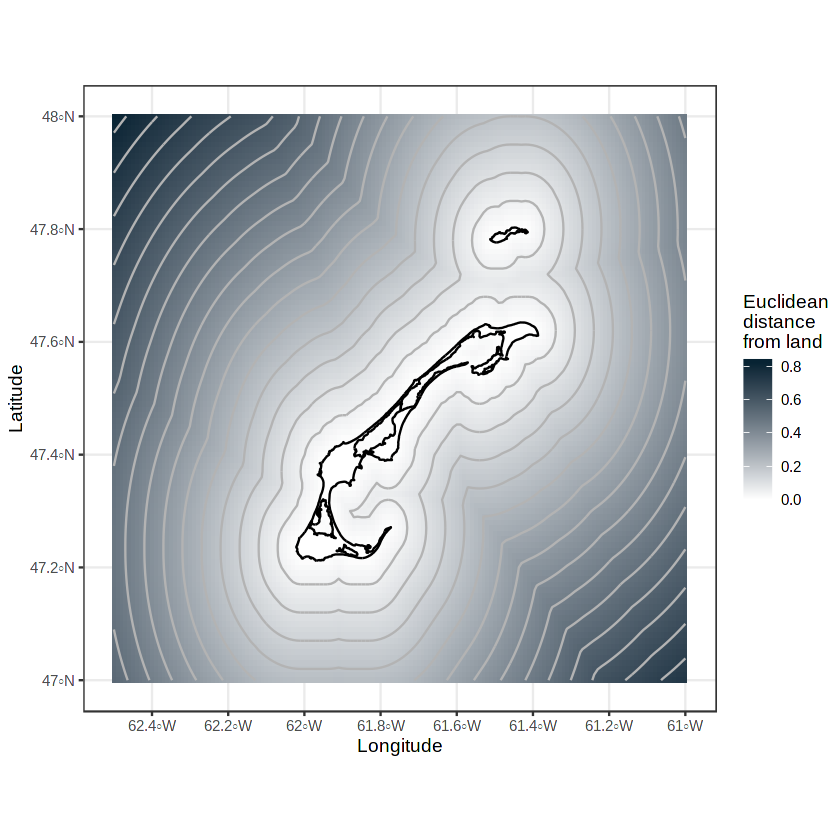

In [25]:
ggplot(idm_map) +
  geom_raster(data=grid, aes(x=long, y=lat, fill=debal)) +
  geom_contour(data=grid, aes(x=long, y=lat, z=debal), binwidth=0.05, colour='grey70') +
  geom_sf() + 
  scale_fill_continuous(low="#ffffff", high="#072333", name = "Euclidean\ndistance\nfrom land") +
  labs(x = "Longitude", y = "Latitude") +
  theme_bw()
ggsave("images/idm-distance.png")

## Importance of the multivariate perspective

It would be unwise to focus only on the most imbalanced axis. The following image shows the importance of a multivariate perspective. Indeed, our [hippo parachutist](https://pixabay.com/vectors/skydiver-fun-hippo-skydiving-151230/) mostly offset on the longitude axis only focussing to turn west will likely fall in the sea!

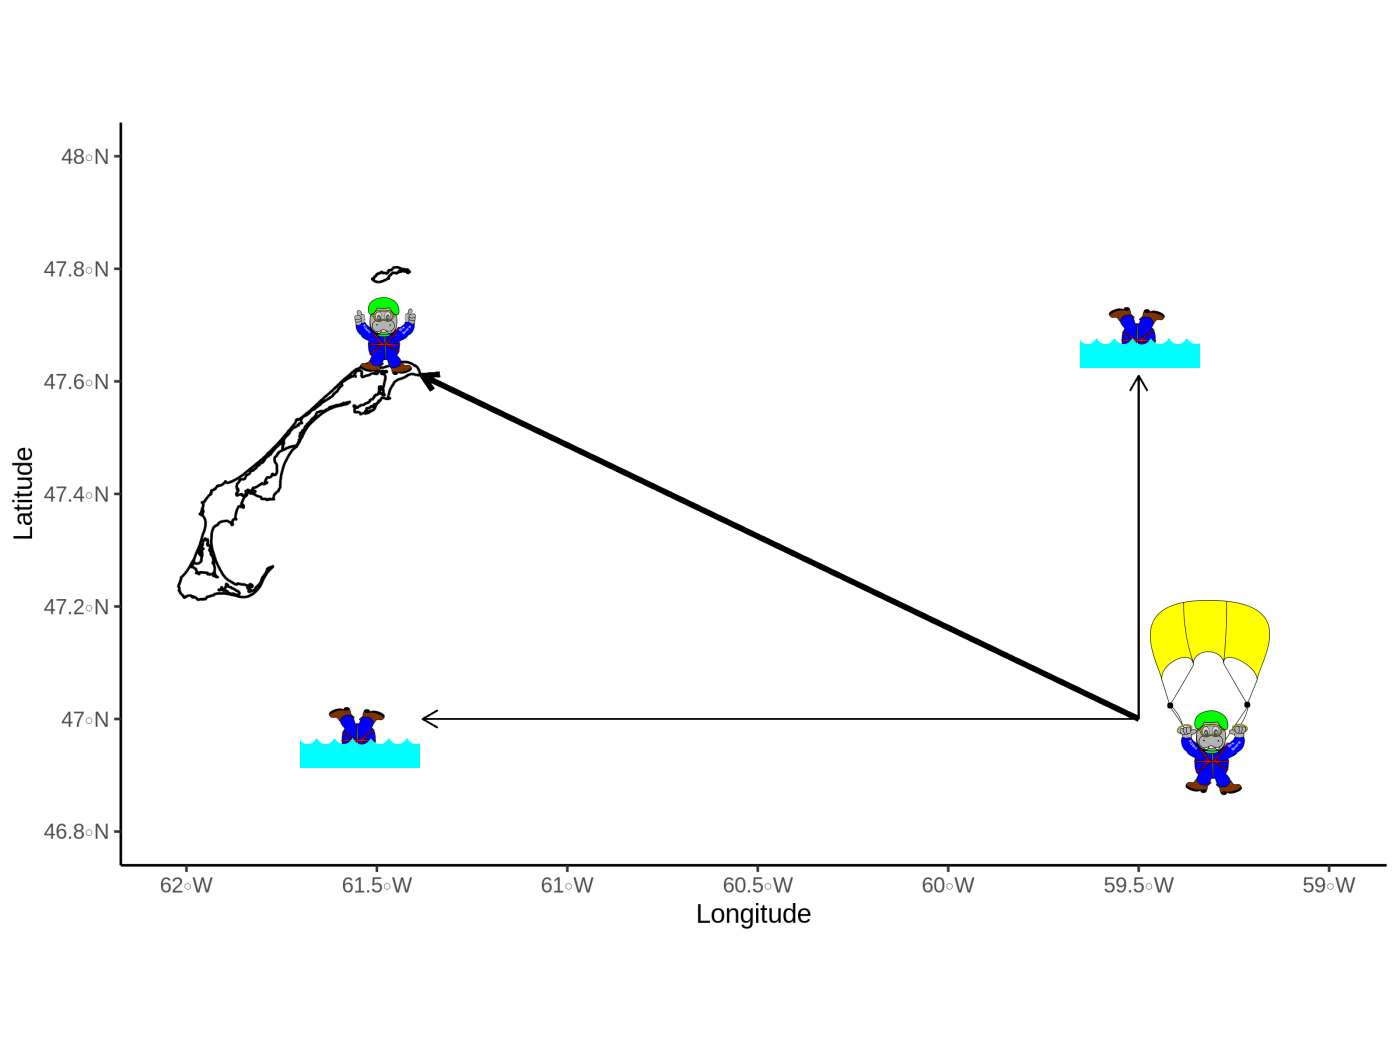

# A tibble: 1 x 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG     1400   1050 sRGB       FALSE   104184 118x118

In [47]:
gg_idm <- ggplot(idm_map) + 
  geom_sf() +
  expand_limits(x = c(-61, -59),
                y = c(46.8, 48)) +
  geom_segment(x=-59.5, xend=-61.38, y=47, yend=47, size = 0.25,
               arrow = arrow(length = unit(0.25, "cm"))) +
  geom_segment(x=-59.5, xend=-59.5, y=47, yend=47.61, size = 0.25,
               arrow = arrow(length = unit(0.25, "cm"))) +
  geom_segment(x=-59.5, xend=-61.38, y=47, yend=47.61, size = 1,
               arrow = arrow(length = unit(0.25, "cm"))) +
  labs(x = "Longitude", y = "Latitude") +
  theme_classic()
ggsave(filename = "images/idm.png",
         width = 8, height = 6, dpi = 300)
hippo_parachute <- image_read("images/SkyDiverHippo.png") %>% image_scale("120")
hippo_sea <- image_read("images/SkyDiverHippo-sea.png") %>% image_scale("120")
hippo_yeah <- image_read("images/SkyDiverHippo-thumbsup.png") %>% image_scale("70")
image_read("images/idm.png") %>% image_scale("1400") %>%
  image_composite(hippo_parachute, offset = "+1150+600") %>%
  image_composite(hippo_sea, offset = "+1080+300") %>%
  image_composite(hippo_sea, offset = "+300+700") %>%
  image_composite(hippo_yeah, offset = "+350+295") %>%
  image_write("images/idm-hippo.png")
image_read("images/idm-hippo.png") 